# *Importing Libraries:*

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import concatenate, Dense, BatchNormalization, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adamax, Nadam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# *Preprocessing:*

In [2]:
path = '/kaggle/input/nosemri/Dataset'
folders = os.listdir(path)
print(folders)

['normal', 'fracture']


In [3]:
def get_image_paths_and_labels_from_folders(dataset_folder):
    paths = []
    labels = []
    for folder_name in os.listdir(dataset_folder):
        folder_path = os.path.join(dataset_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                if os.path.isfile(img_path):
                    paths.append(img_path)
                    labels.append(folder_name)
    return paths, labels

image_paths, labels = get_image_paths_and_labels_from_folders(path)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
df.head()

,image_path,label
0,/kaggle/input/nosemri/Dataset/normal/1402-08-0...,normal
1,/kaggle/input/nosemri/Dataset/normal/1401-11-1...,normal
2,/kaggle/input/nosemri/Dataset/normal/1401-12-2...,normal
3,/kaggle/input/nosemri/Dataset/normal/1401-08-2...,normal
4,/kaggle/input/nosemri/Dataset/normal/1402-01-1...,normal


In [4]:
def read_images_from_df(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        img = img[:img.shape[1], :]
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

images, labels = read_images_from_df(df)

In [5]:
def gaussian_noise(image):
    mean=0
    std=5
    noise = np.random.normal(mean, std, image.shape)
    
    # Add the noise to the image
    noisy_image = image + noise
    
    # Clip pixel values to the range [0, 255] (assuming image is in uint8 format)
    noisy_image = np.clip(noisy_image, 0, 255)
    
    # Convert back to uint8 format
    noisy_image = noisy_image.astype(np.uint8)
    
    return noisy_image

In [6]:
def preprocessing(img):
    img = img[:img.shape[1], :]
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))

    sharpened_image = sharpen_image(img)

    kernel = np.ones((3,3), np.uint8)
    img_eroded = cv2.erode(sharpened_image, kernel, iterations=1)
    

    
#     dilated_image = cv2.dilate(img_eroded, kernel, iterations=1)

#     blurred_image = cv2.GaussianBlur(img_eroded, (5,5), 0)  # Kernel size (5, 5)

#     noise = gaussian_noise(img_eroded)


#     gray = cv2.cvtColor(sharpen_image, cv2.COLOR_BGR2GRAY)

    # Histogram Equalization
#     equalized_image = cv2.equalizeHist(img)
    
#     RGB = cv2.cvtColor(noise, cv2.COLOR_GRAY2RGB)

#     # Smoothing/Blurring (Gaussian Blur)
#     blurred_image = cv2.GaussianBlur(sharpened_image, (5,5), 0)  # Kernel size (5, 5)

    return img_eroded

In [7]:
def sharpen_image(image, kernel_size=(3, 3), strength=0.5):
    # Create a Laplacian kernel for edge detection
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    # Apply the kernel to the image
    sharpened = cv2.filter2D(image, -1, kernel)

    # Increase the strength of the sharpening effect
    sharpened = cv2.addWeighted(image, 1 + strength, sharpened, -strength, 0)

    return sharpened

In [8]:
for i in range (len(images)):
    images[i] = preprocessing(images[i])

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [10]:
batch_size = 32

one_hot_label = to_categorical(labels)

X_train, X_val_test, y_train, y_val_test = train_test_split(images, one_hot_label, test_size=0.2, random_state=42)

# Split the combined validation-test set into separate validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    brightness_range=[0.8, 1.3],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1./255) 

test_datagen = ImageDataGenerator(rescale=1./255) 



# Create generator for training data
train_generator = train_datagen.flow(
    np.array(X_train), 
    y_train, 
    batch_size=batch_size,
    shuffle=True,
)

# Create generator for Validation data
validation_generator = validation_datagen.flow(
    np.array(X_val),
    y_val,
    batch_size=batch_size,
    shuffle=False,  
)

# Create generator for Test data
test_generator = test_datagen.flow(
    np.array(X_test),
    y_test,
    batch_size=batch_size,
    shuffle=False,  
)

### Show sample:

In [11]:
classes = np.unique(y_train)
classes

array([0., 1.], dtype=float32)

In [12]:
y_train[0]

array([0., 1.], dtype=float32)

In [13]:
img, lable = validation_generator.next()
img.shape

(32, 224, 224, 3)

In [14]:
lable.shape

(32, 2)

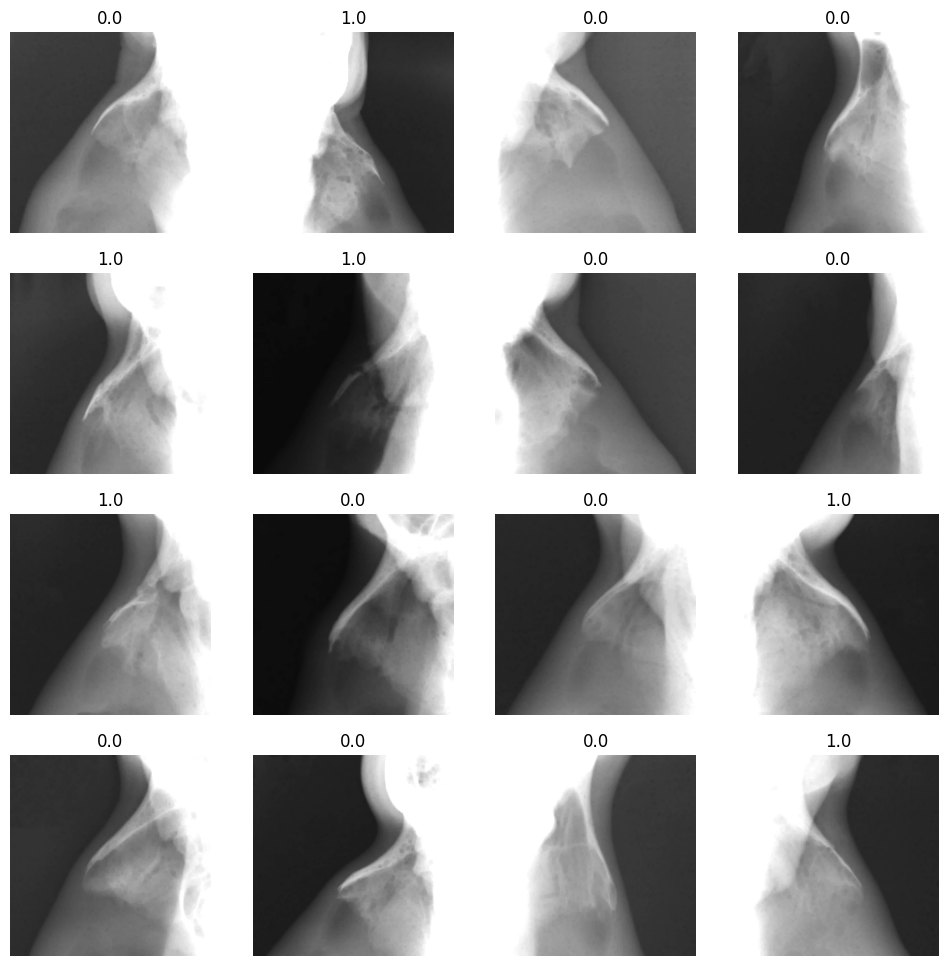

In [15]:
def show_sample(img, lable):
    plt.figure(figsize= (12, 12))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        index = np.argmax(lable[i]) 
        class_name = classes[index]
        plt.title(class_name)
        plt.axis('off')
    plt.show()
    
show_sample(img, lable)

In [16]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='darkblue')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='darkblue')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()
    
    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss))) 

# *Model Structure:*

In [17]:
# global parameters:
EPOCHS = 100
IMG_SHAPE = (224, 224, 3)
LR = 1e-3
OPTIMIZER = Adamax(LR)
LOSS = CategoricalCrossentropy()
METRICS = ['accuracy']

In [18]:
def lr_schedule(epoch):
    initial_learning_rate = LR
    decay = 0.98
    lr = initial_learning_rate * decay**(1.25 * epoch)
    return lr

In [19]:
def lr_schedule2(epoch):
    if epoch < 60:
        return 0.001
    elif epoch < 80:
        return 0.0003
    else:
        return 0.0001

In [20]:
lr_scheduler = LearningRateScheduler(lr_schedule)

# *Convolutional Neural Network:*
### *Using Transfer Learning...*

## VGG16:

In [21]:
from tensorflow.keras.applications import VGG16, ResNet101V2, InceptionV3, MobileNetV3Large

In [22]:
expert1 = VGG16(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert1.trainable = True
print("Number of layers in the expert1: ", len(expert1.layers))

for layer in expert1.layers[:int(len(expert1.layers) * 0.7)]:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step
Number of layers in the expert1:  19


## ResNet101V2

In [23]:
expert2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert2.trainable = True
print("Number of layers in the expert2: ", len(expert2.layers))

for layer in expert2.layers[:int(len(expert2.layers) * 0.7)]:
    layer.trainable = False

171317808/171317808 [==============================] - 1s 0us/step
Number of layers in the expert2:  377


## InceptionV3

In [24]:
expert3 = InceptionV3(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert3.trainable = True
print("Number of layers in the expert3: ", len(expert3.layers))

for layer in expert3.layers[:int(len(expert3.layers) * 0.7)]:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step
Number of layers in the expert3:  311


## MobileNetV3Large

In [25]:
expert4 = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert4.trainable = True
print("Number of layers in the expert4: ", len(expert4.layers))

for layer in expert4.layers[:int(len(expert4.layers) * 0.7)]:
    layer.trainable = False

12683000/12683000 [==============================] - 0s 0us/step
Number of layers in the expert4:  263


In [26]:
def build_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)

    # Gate
    conv_gate = Conv2D
    flat_gate = Flatten(name = 'Gate')(input_img)
    drop1_gate = Dropout(0.4)(flat_gate)
    bn1_gate = BatchNormalization()(drop1_gate)
    dense_gate = Dense(128, 'relu')(bn1_gate)
    drop2_gate = Dropout(0.4)(dense_gate)
    bn2_gate = BatchNormalization()(drop2_gate)
    
    # VGG16
    conv1 = expert1(input_img)
    flat1 = Flatten()(conv1)
    drop1_1 = Dropout(0.5)(flat1)
    bn1_1 = BatchNormalization()(drop1_1)
    dense1_1 = Dense(128, 'relu')(bn1_1)
    drop1_2 = Dropout(0.4)(dense1_1)
    bn1_2 = BatchNormalization()(drop1_2)
    
#     dense1_2 = Dense(64, 'relu')(bn1_2)
#     drop1_3 = Dropout(0.3)(dense1_2)
#     bn1_3 = BatchNormalization()(drop1_3)
#     output_expert1 = Dense(len(classes), "sigmoid")(bn1_3)

    # ResNet101V2
    conv2 = expert2(input_img)
    flat2 = Flatten()(conv2)
    drop2_1 = Dropout(0.5)(flat2)
    bn2_1 = BatchNormalization()(drop2_1)
    dense2_1 = Dense(128, 'relu')(bn2_1)
    drop2_2 = Dropout(0.4)(dense2_1)
    bn2_2 = BatchNormalization()(drop2_2)
    
#     dense2_2 = Dense(64, 'relu')(bn2_2)
#     drop2_3 = Dropout(0.3)(dense2_2)
#     bn2_3 = BatchNormalization()(drop2_3)
#     output_expert2 = Dense(len(classes), "sigmoid")(bn2_3)

    # InceptionV3
    conv3 = expert3(input_img)
    flat3 = Flatten()(conv3)
    drop3_1 = Dropout(0.5)(flat3)
    bn3_1 = BatchNormalization()(drop3_1)
    dense3_1 = Dense(128, 'relu')(bn3_1)
    drop3_2 = Dropout(0.4)(dense3_1)
    bn3_2 = BatchNormalization()(drop3_2)
    
#     dense3_2 = Dense(64, 'relu')(bn3_2)
#     drop3_3 = Dropout(0.3)(dense3_2)
#     bn3_3 = BatchNormalization()(drop3_3)
#     output_expert3 = Dense(len(classes), "sigmoid")(bn3_3)

    # MobileNetV3Large
    conv4 = expert4(input_img)
    flat4 = Flatten()(conv4)
    drop4_1 = Dropout(0.5)(flat4)
    bn4_1 = BatchNormalization()(drop4_1)
    dense4_1 = Dense(128, 'relu')(bn4_1)
    drop4_2 = Dropout(0.4)(dense4_1)
    bn4_2 = BatchNormalization()(drop4_2)
    
#     dense4_2 = Dense(64, 'relu')(bn4_2)
#     drop4_3 = Dropout(0.3)(dense4_2)
#     bn4_3 = BatchNormalization()(drop4_3)
#     output_expert4 = Dense(len(classes), "sigmoid")(bn4_3)


    merged = concatenate([bn1_2, bn2_2, bn3_2, bn4_2, bn2_gate])
    
    # Output
    dense1_out = Dense(128, 'relu')(merged)
    drop1_out = Dropout(0.4)(dense1_out)
    bn1_out = BatchNormalization()(drop1_out)
    dense2_out = Dense(16, 'relu')(bn1_out)
    drop2_out = Dropout(0.3)(dense2_out)
    bn2_out = BatchNormalization()(drop2_out)
    
    output = Dense(len(classes), activation='softmax')(bn2_out)

    model = tf.keras.Model(inputs=input_img, outputs=output)

    return model

model = build_model(IMG_SHAPE)
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [27]:
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dropout(0.5),
#     BatchNormalization(),
#     Dense(512, 'relu'),
#     Dropout(0.4),
#     BatchNormalization(),
#     Dense(128, 'relu'),
#     Dropout(0.3),
#     BatchNormalization(),
#     Dense(16, 'relu'),
#     BatchNormalization(),
#     Dense(len(classes), "sigmoid")
# ])

# model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 resnet101v2 (Functional)    (None, 7, 7, 2048)           4262656   ['input_5[0][0]']             
                                                          0                                       
                                                                                              

In [29]:
len(model.trainable_variables)

252

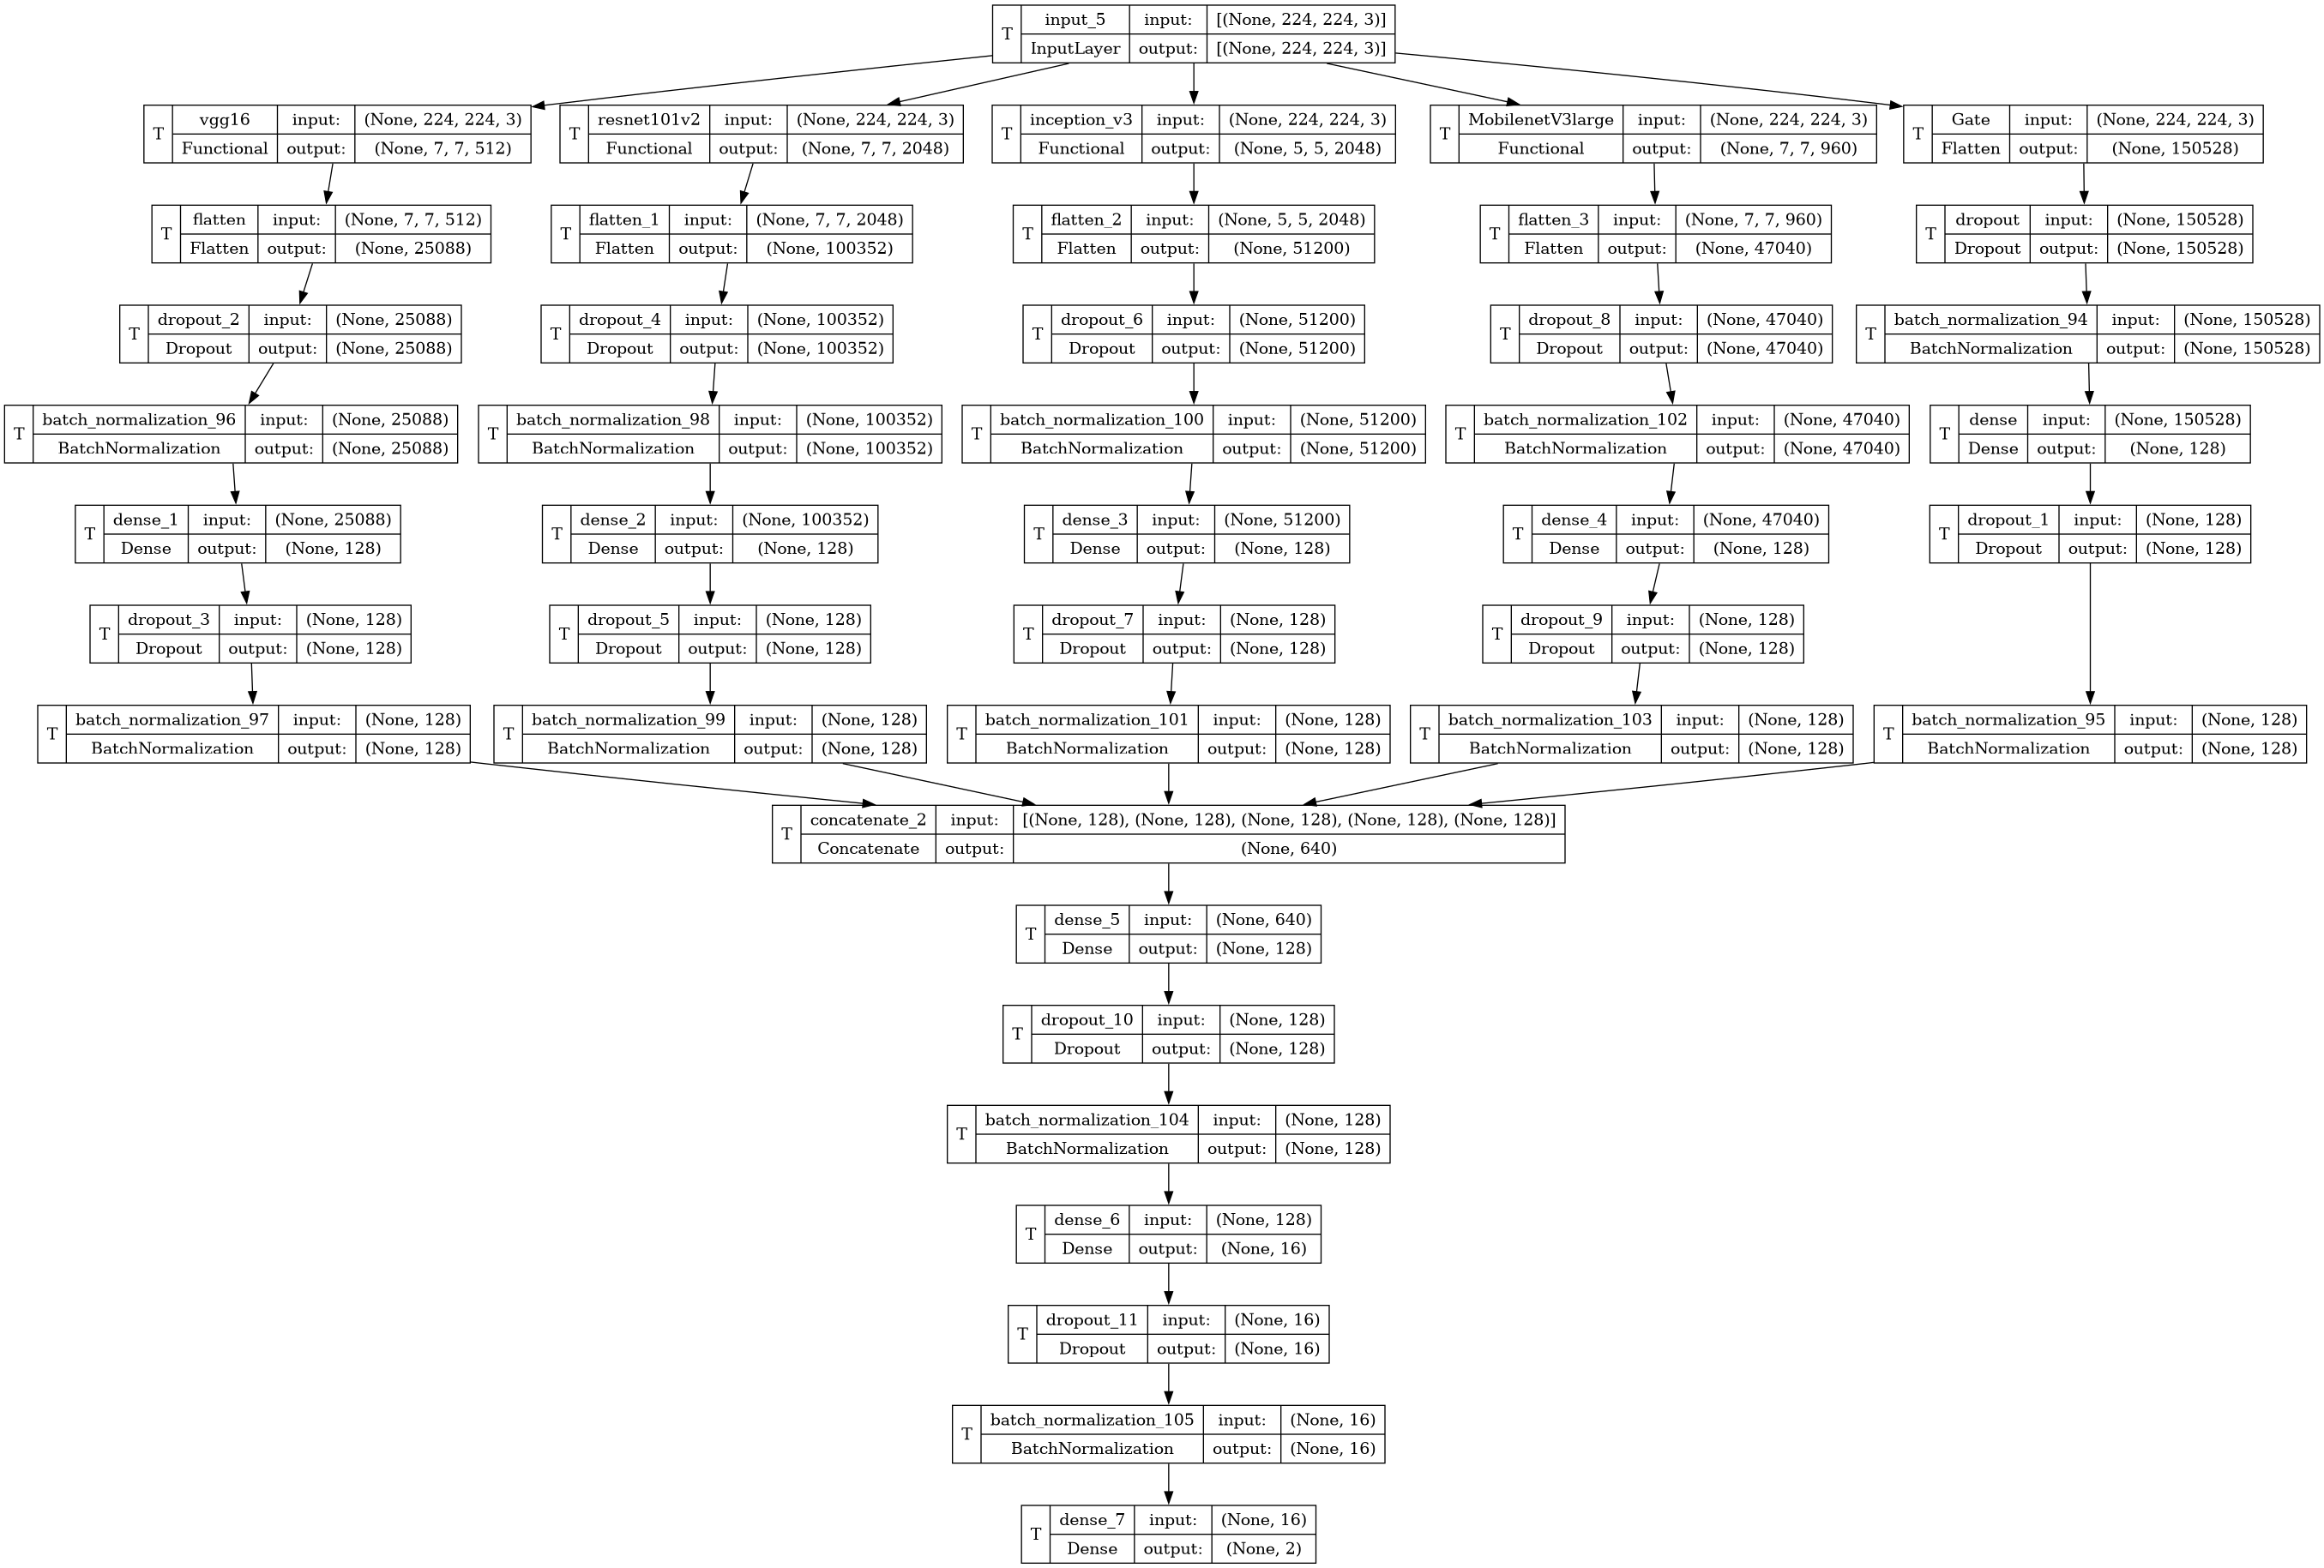

In [30]:
plot_model(model, show_shapes = True, show_trainable = True)

In [31]:
# from keras.callbacks import EarlyStopping

# # Define the early stopping callback 
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [32]:
hist = model.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, callbacks=[lr_scheduler])

Epoch 1/100
48/48 [==============================] - 118s 1s/step - loss: 1.0270 - accuracy: 0.4848 - val_loss: 2.1264 - val_accuracy: 0.4684 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 31s 639ms/step - loss: 0.9063 - accuracy: 0.4980 - val_loss: 1.0343 - val_accuracy: 0.4737 - lr: 9.7506e-04
Epoch 3/100
48/48 [==============================] - 31s 638ms/step - loss: 0.8398 - accuracy: 0.5125 - val_loss: 0.9475 - val_accuracy: 0.3789 - lr: 9.5075e-04
Epoch 4/100
48/48 [==============================] - 31s 633ms/step - loss: 0.8221 - accuracy: 0.5284 - val_loss: 0.7556 - val_accuracy: 0.4632 - lr: 9.2704e-04
Epoch 5/100
48/48 [==============================] - 31s 636ms/step - loss: 0.8190 - accuracy: 0.5079 - val_loss: 0.7218 - val_accuracy: 0.5158 - lr: 9.0392e-04
Epoch 6/100
48/48 [==============================] - 31s 636ms/step - loss: 0.7925 - accuracy: 0.5244 - val_loss: 0.7099 - val_accuracy: 0.5789 - lr: 8.8138e-04
Epoch 7/100
48/48 [=====================

Maximum Accuracy of Training set: 95.778
Minimum Loss of Trainig set: 0.13514623

Maximum Accuracy of Validation set: 83.158
Minimum Loss of Validation set: 0.44049859



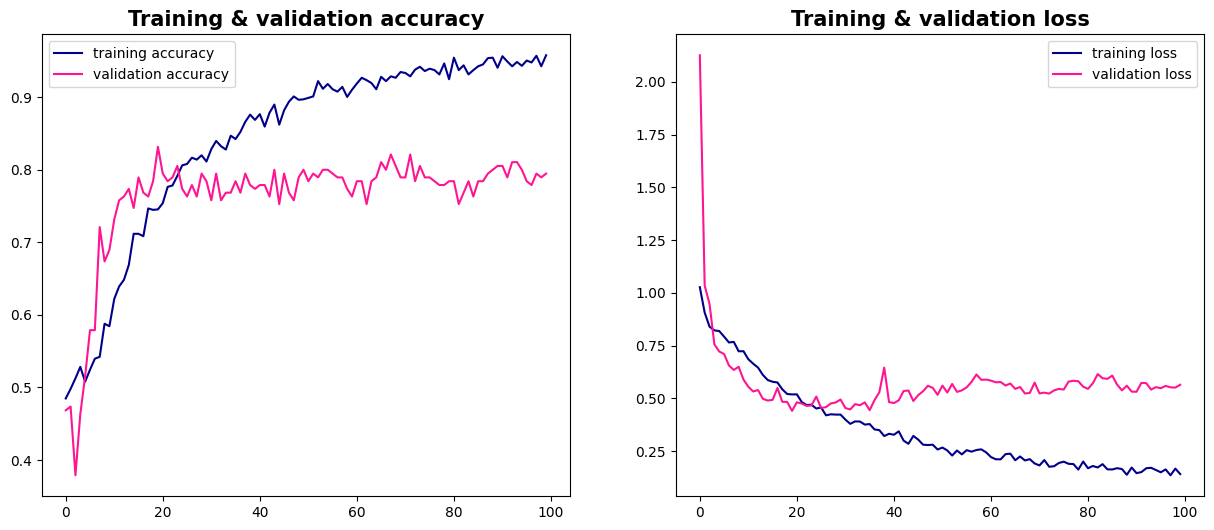

In [33]:
draw_plot(hist)

In [34]:
# model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [35]:
# total_epochs = EPOCHS + 30

# hist_fine = model.fit(train_generator, 
#                               validation_data = validation_generator, 
#                               epochs = total_epochs, 
#                               initial_epoch = hist.epoch[-1],
#                               callbacks=[lr_scheduler])

## *Evaluation:*

In [36]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy * 100)

6/6 [==============================] - 2s 379ms/step - loss: 0.5075 - accuracy: 0.8105
Test accuracy : 81.05263113975525


In [37]:
# Generate predictions
predictions = model.predict(test_generator)

6/6 [==============================] - 7s 376ms/step


In [38]:
y_pred = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test, axis=1)

## *Calculate classification report:*

In [39]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')

Precision: 0.810874
Recall: 0.810526


In [40]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.83      0.81      0.82       100
    fracture       0.79      0.81      0.80        90

    accuracy                           0.81       190
   macro avg       0.81      0.81      0.81       190
weighted avg       0.81      0.81      0.81       190



## *Compute confusion matrix:*

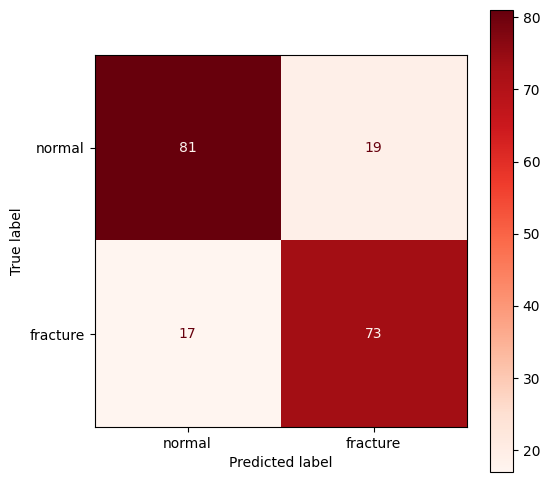

In [41]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['normal', 'fracture']

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(6, 6))
display.plot(ax=ax, values_format='.4g', cmap='Reds')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Assuming y_true contains true labels and y_pred contains predicted probabilities
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true contains true labels and y_pred contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## *Save Model:*

In [ ]:
model.save('model.h5')